# MSDS Assignment 4: Sentiment Analysis of Amazon Reviews
## Category: Video games
## Author: Ben Xiao

# Setup

In [1]:
###### Setup #######
# Import packages
import sys
import pandas as pd
import numpy as np
import os
import re, string
import nltk
import gensim
import multiprocessing
import matplotlib
import sklearn
import time
import tensorflow as tf
from tensorflow import keras

In [2]:
# Import support libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from collections import OrderedDict

# Import sklearn things
from sklearn.model_selection import KFold, cross_validate, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Import Keras things
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Embedding, Input, Conv1D, MaxPooling1D, LSTM, \
                                        GRU, Dropout, BatchNormalization, Dense, \
                                        Flatten, GlobalMaxPooling1D, Bidirectional, \
                                        LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adagrad, Adam, SGD


In [3]:
# Check package versions
print('Check package version:')
print('Python: {}'.format(sys.version))
print('pandas: {}'.format(pd.__version__))
print('NumPy: {}'.format(np.__version__))
print('ReGex: {}'.format(re.__version__))
print('scikit-learn: {}'.format(sklearn.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))

Check package version:
Python: 3.8.2 (default, Apr 27 2020, 15:53:34) 
[GCC 9.3.0]
pandas: 1.0.3
NumPy: 1.18.3
ReGex: 2.2.1
scikit-learn: 0.22.2.post1
matplotlib: 3.2.1


In [4]:
# Text parsing settings
STEMMING = False
seed = 88
cores = multiprocessing.cpu_count()
np.random.seed(88)

# Import data

In [5]:
# Import and check data
data_path = 'data_files/short_reviews.pkl'
df = pd.read_pickle(data_path)
df.head()

,overall,reviewText,asin,word_counts
0,1,I used to play this game years ago and loved i...,0439381673,139
1,3,The game itself worked great but the story lin...,0439381673,145
2,4,I had to learn the hard way after ordering thi...,0439381673,447
3,1,The product description should state this clea...,0439381673,157
4,4,I would recommend this learning game for anyon...,0439381673,120


In [6]:
############################
# DEVELOPMENT SET - comment out when done
############################
# shuffle dataframe rows before splitting
df = df.sample(frac=1, random_state=seed)
df = df.iloc[:8000]

# Global functions

In [7]:
# Function to clean text
def clean_doc(doc):
    # split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 2]
    # filter out tokens more than 20 characters long
    tokens = [word for word in tokens if len(word) < 21]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # word stemming Commented
    if STEMMING:
        ps=PorterStemmer()
        tokens=[ps.stem(word) for word in tokens]
    return tokens

In [8]:
# Function to record time
def parse_time(start_time, end_time):
    runtime = end_time - start_time
    return round(runtime, 3)

# Clean docs

In [9]:
# Generate documents
docs = list()

In [10]:
# Clean training set
print('Start cleaning docs...')
start_clean = time.time()
for i in range(len(df)):
    temp_text = df.reviewText.iloc[i]
    cleaned_doc = clean_doc(temp_text)

    combined_text = ' '.join(cleaned_doc)
    docs.append(combined_text)

end_clean = time.time()
print('Finished cleaning docs...')
clean_runtime = parse_time(start_clean, end_clean)
print('Cleaning runtime: {}'.format(clean_runtime))
#print(docs[0])

Start cleaning docs...
Finished cleaning docs...
Cleaning runtime: 1.324


# Split into train, validation, test sets

In [11]:
ind = np.random.randint(0, len(df) , size = len(df))
ind

train_ind = int(0.6 * len(df)) + 1
val_ind = int(0.2 * len(df)) + train_ind + 1
test_ind = int(0.2 * len(df)) + val_ind - 1

In [12]:
train_ind, val_ind, test_ind,

(4801, 6402, 8001)

In [13]:
train = df.iloc[:train_ind]
rf_train = df.iloc[:val_ind]
val = df.iloc[train_ind:val_ind]

test = df.iloc[val_ind:]

In [14]:
len(rf_train)

6402

In [15]:
len(train), len(val), len(test) # 60, 20, 20 split

(4801, 1601, 1598)

In [16]:
train_docs = docs[:train_ind]
rf_train_docs = docs[:val_ind]
val_docs = docs[train_ind:val_ind]
test_docs = docs[val_ind:]

In [17]:
len(train_docs)

4801

# Check label distribution

In [18]:
len(train)

4801

In [19]:
train.overall.value_counts()

5    2404
4     904
1     684
3     455
2     354
Name: overall, dtype: int64

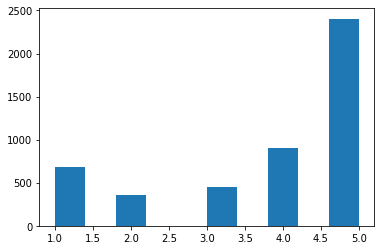

In [20]:
train.overall.hist(
    grid=False
)

In [21]:
val.overall.value_counts()

5    801
4    291
1    246
3    153
2    110
Name: overall, dtype: int64

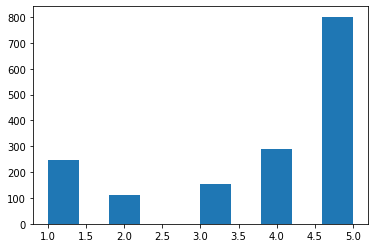

In [22]:
val.overall.hist(
    grid=False
)

In [23]:
test.overall.value_counts()

5    862
4    282
1    201
3    153
2    100
Name: overall, dtype: int64

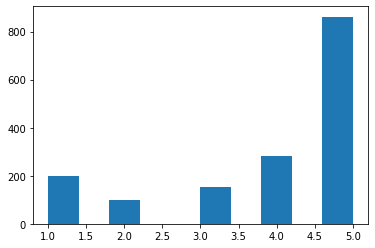

In [24]:
test.overall.hist(grid=False)

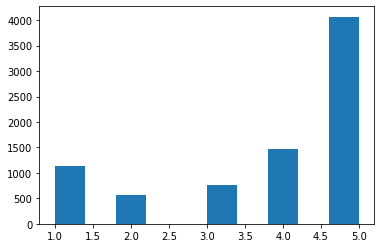

In [25]:
df.overall.hist(grid=False)

# TF-IDF - 100 dimension, 2-gram

In [26]:
ndim = 100
n_grams = 2

# 1. TF-IDF
tfidf100 = TfidfVectorizer(ngram_range=(1, n_grams),
                                max_features=ndim)
tfidf100_train_matrix = tfidf100.fit_transform(train_docs).toarray()
tfidf100_val_matrix = tfidf100.transform(val_docs).toarray()
tfidf100_test_matrix = tfidf100.transform(test_docs).toarray()

rf_tfidf100_train = tfidf100.fit_transform(rf_train_docs).toarray()
rf_tfidf100_test = tfidf100.transform(test_docs).toarray()

In [27]:
# Export arrays for modeling
np.save('embeddings_arrays/tfidf100_train.npy', tfidf100_train_matrix)
np.save('embeddings_arrays/tfidf100_val.npy', tfidf100_val_matrix)
np.save('embeddings_arrays/tfidf100_test.npy', tfidf100_test_matrix)
np.save('embeddings_arrays/tfidf100_rf_train.npy', rf_tfidf100_train)

In [28]:
#{k: v for k, v in sorted(tfidf_100.vocabulary_.items(), key=lambda item: item[1], reverse=True)}

# TF-IDF 200 dimension, 1-gram

In [29]:
tfidf200 = TfidfVectorizer(max_features=200) # default n-gram is 1
tfidf200_train_matrix = tfidf200.fit_transform(train_docs).toarray()
tfidf200_val_matrix = tfidf200.transform(val_docs).toarray()
tfidf200_test_matrix = tfidf200.transform(test_docs).toarray()
rf_tfidf200_train = tfidf200.fit_transform(rf_train_docs).toarray()

In [30]:
# Export matrices
np.save('embeddings_arrays/tfidf200_train.npy', tfidf200_train_matrix)
np.save('embeddings_arrays/tfidf200_val.npy', tfidf200_val_matrix)
np.save('embeddings_arrays/tfidf200_test.npy', tfidf200_test_matrix)
np.save('embeddings_arrays/tfidf200_rf_train.npy', rf_tfidf200_train)

# GloVe - 100 dimension

Tutorial: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

In [31]:
# Required packages
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding

In [32]:
glove100_path = 'glove.6B/glove.6B.100d.txt'
ndim = 100
glove100_embeddings_index = {}
with open(glove100_path) as f:
    for line in f:
        values = line.split()
        ps=PorterStemmer()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove100_embeddings_index[word] = coefs

print('Found %s word vectors.' % len(glove100_embeddings_index))

Found 400000 word vectors.


In [33]:
from nltk.tokenize import word_tokenize
word_count = lambda sentence: len(word_tokenize(sentence))
length_long_sentence = len(max(train_docs, key=word_count))

In [34]:
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(train_docs)
sequences = tokenizer.texts_to_sequences(train_docs)
glove100_train = pad_sequences(sequences, length_long_sentence)
word_index = tokenizer.word_index
len(word_index)

glove100_test = tokenizer.texts_to_sequences(test_docs)
glove100_test = np.asarray(pad_sequences(glove100_test, length_long_sentence))
glove100_val = tokenizer.texts_to_sequences(val_docs)
glove100_val = np.asarray(pad_sequences(glove100_val, length_long_sentence))

In [35]:
# Required or to_categorical creates 6 labels
#labels = np.asarray(df.overall.apply(lambda x: x-1))
train_labels = np.asarray(train.overall.apply(lambda x: x-1))
val_labels = np.asarray(val.overall.apply(lambda x: x-1))
test_labels = np.asarray(test.overall.apply(lambda x: x-1))
rf_train_labels = np.asarray(rf_train.overall.apply(lambda x: x-1))


train_labels = to_categorical(train_labels, num_classes=5) # number of classes, 1-5 ratings
glove_val_labels = to_categorical(val_labels, num_classes=5)
glove_test_labels = to_categorical(test_labels, num_classes=5)
rf_train_labels = to_categorical(rf_train_labels, num_classes = 5)

In [36]:
glove100_train.shape, glove100_val.shape, train_labels.shape, glove_val_labels.shape, glove_test_labels.shape

((4801, 1689), (1601, 1689), (4801, 5), (1601, 5), (1598, 5))

In [37]:
# Save labels
np.save('embeddings_arrays/train_labels.npy', train_labels)
np.save('embeddings_arrays/val_labels.npy', val_labels)
np.save('embeddings_arrays/test_labels.npy', test_labels)

In [38]:
glove100_embedding_matrix = np.zeros((len(word_index) + 1, ndim))
for word, i in word_index.items():
    embedding_vector = glove100_embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        glove100_embedding_matrix[i] = embedding_vector

In [39]:
from tensorflow.keras.layers import Embedding

glove100_embedding_layer = Embedding(len(word_index) + 1, # input len(embedding array)
                            100,
                            weights=[glove100_embedding_matrix],
                            input_length=length_long_sentence,
                            trainable=False)

In [40]:
sequence100_input = Input(shape=(100,), dtype='int32')
glove100embedded_sequences = glove100_embedding_layer(sequence100_input)


In [41]:
# Export weights
np.save('embeddings_arrays/glove100_weights.npy', glove100_embedding_matrix)

# Glove 200 dimension

In [42]:
ndim = 200

In [43]:
glove200_path = 'glove.6B/glove.6B.200d.txt'
glove200_embeddings_index = {}
with open(glove200_path) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        glove200_embeddings_index[word] = coefs

print('Found %s word vectors.' % len(glove200_embeddings_index))

Found 400000 word vectors.


In [44]:
texts = list()
tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(train_docs)
sequences = tokenizer.texts_to_sequences(train_docs)
glove200_train = pad_sequences(sequences, length_long_sentence)
word_index = tokenizer.word_index
len(word_index)

glove200_test = tokenizer.texts_to_sequences(test_docs)
glove200_test = pad_sequences(glove200_test, length_long_sentence)
glove200_val = tokenizer.texts_to_sequences(val_docs)
glove200_val = pad_sequences(glove200_val, length_long_sentence)
# Reuse glove train/val/test labels

In [45]:
glove200_embedding_matrix = np.zeros((len(word_index) + 1, ndim))
for word, i in word_index.items():
    embedding_vector = glove200_embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        glove200_embedding_matrix[i] = embedding_vector

In [46]:
glove200_embedding_layer = Embedding(len(word_index) + 1,
                            200,
                            weights=[glove200_embedding_matrix],
                            input_length=length_long_sentence,
                            trainable=False)

sequence200_input = Input(shape=(200,), dtype='int32')
glove200_embedded_sequences = glove200_embedding_layer(sequence200_input)

In [47]:
# Export glove200 weights
np.save('embeddings_arrays/glove200_weights.npy', glove200_embedding_matrix)

glove_100_embedding_layer and glove_200_embedding_layer are now layers that go in as training layers.

# Modeling Experiments

In [48]:
# model, train mse, train time, val loss, test mse
regression_results = list()

# model, train time, train f1, val f1, test loss, test f1
classifier_results = list()

## Random Forest

In [49]:
rf_train_labels = np.asarray(rf_train.overall)
rf_test_labels = np.asarray(test.overall)

### TF-IDF 100 terms

Try both classifier and regressor to compare F1 and RMSE scores.

In [50]:
data = dict()
rfc = RandomForestClassifier(random_state=seed, n_estimators=100)
rfr = RandomForestRegressor(random_state=seed, n_estimators=100)

start = time.time()
rfc.fit(rf_tfidf100_train, rf_train_labels)
end = time.time()

In [51]:
cv_scores = cross_val_score(rfc, rf_tfidf100_train, 
                    rf_train_labels, cv=5, scoring='f1_macro', 
                    n_jobs=-1)

train_time = parse_time(start, end)
train_time, round(np.mean(cv_scores),3)

(1.756, 0.251)

In [52]:
rfc_train_preds = rfc.predict(rf_tfidf100_train)
rfc_preds = rfc.predict(tfidf100_test_matrix)

In [53]:
data['model'] = 'RF TF-IDF 100 terms'
data['train_f1'] = round(f1_score(rfc_train_preds, rf_train_labels, average='macro'), 3)
data['train_time'] = parse_time(start, end)
data['val_f1'] = round(np.mean(cv_scores), 3)
data['test_f1'] = round(f1_score(rfc_preds, test_labels, average='macro'), 3)
classifier_results.append(data)
data

{'model': 'RF TF-IDF 100 terms',
 'train_f1': 0.986,
 'train_time': 1.756,
 'val_f1': 0.251,
 'test_f1': 0.03}

### Regressor

In [54]:
data = dict()
start = time.time()
rfr.fit(rf_tfidf100_train, rf_train_labels)
end = time.time()

train_time = parse_time(start, end)

In [55]:
cv_scores = cross_val_score(rfr, rf_tfidf100_train, rf_train_labels,
                    n_jobs=-1, scoring='neg_mean_squared_error')

In [56]:
rfr_train_preds = rfr.predict(rf_tfidf100_train)
rfr_preds = rfr.predict(tfidf100_test_matrix)
mean_squared_error(rfr_train_preds, rf_train_labels)
mean_squared_error(rfr_preds, rf_test_labels)

2.289336309336181

In [57]:
data['model'] = 'RF TF-IDF 100 dim'
data['train_mse'] = round(mean_squared_error(rfr_train_preds, rf_train_labels), 3)
data['train_time'] = train_time
data['val_mse'] = round(np.abs(np.mean(cv_scores)), 3)
data['test_mse'] = round(mean_squared_error(rfr_preds, rf_test_labels), 3)
regression_results.append(data)
data

{'model': 'RF TF-IDF 100 dim',
 'train_mse': 0.291,
 'train_time': 12.075,
 'val_mse': 1.793,
 'test_mse': 2.289}

### TF-IDF 200 terms

### Classifier

In [58]:
data = dict()
start = time.time()
rfc.fit(rf_tfidf200_train, rf_train_labels)
end = time.time()

cv_scores = cross_val_score(rfc, rf_tfidf200_train, 
                    rf_train_labels, cv=3, scoring='f1_macro', 
                    n_jobs=-1)

In [59]:
rfc_train_preds = rfc.predict(rf_tfidf200_train)
rfc_preds = rfc.predict(tfidf200_test_matrix)

f1_score(rfc_train_preds, rf_train_labels, average='macro')
f1_score(rfc_preds, test_labels, average='macro')

0.024386237172496713

In [60]:
data['model'] = 'RF TF-IDF 200 terms'
data['train_f1'] = round(f1_score(rfc_train_preds, rf_train_labels, average='macro'), 3)
data['train_time'] = parse_time(start, end)
data['val_f1'] = round(np.mean(cv_scores), 3)
data['test_f1'] = round(f1_score(rfc_preds, test_labels, average='macro'), 3)
classifier_results.append(data)
data

{'model': 'RF TF-IDF 200 terms',
 'train_f1': 0.998,
 'train_time': 2.066,
 'val_f1': 0.252,
 'test_f1': 0.024}

### Regressor

In [61]:
data = dict()
start = time.time()
rfr.fit(rf_tfidf200_train, rf_train_labels)
end = time.time()

cv_scores = cross_val_score(rfr, rf_tfidf200_train, rf_train_labels,
                    n_jobs=-1, scoring='neg_mean_absolute_error')

In [62]:
rfr_train_preds = rfr.predict(rf_tfidf200_train)
rfr_preds = rfr.predict(tfidf200_test_matrix)

mean_squared_error(rfr_train_preds, rf_train_labels)
mean_squared_error(rfr_preds, test_labels)

2.7751832473113383

In [63]:
data['model'] = 'RF TF-IDF 200 dim'
data['train_mse'] = round(mean_squared_error(rfr_train_preds, rf_train_labels), 3)
data['train_time'] = train_time
data['val_mse'] = round(np.abs(np.mean(cv_scores)), 3)
data['test_mse'] = round(mean_squared_error(rfr_preds, test_labels), 3)
regression_results.append(data)
data

{'model': 'RF TF-IDF 200 dim',
 'train_mse': 0.232,
 'train_time': 12.075,
 'val_mse': 1.012,
 'test_mse': 2.775}

## Dense Neural Network

### GloVe 100 dimension

In [64]:
sequence100_input = Input(shape=(length_long_sentence,), dtype='int32')
glove100_embedded_sequences = glove100_embedding_layer(sequence100_input)

model = Sequential([
    sequence100_input,
    glove100_embedding_layer,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation = 'softmax')
])

model.summary()

opt = 'rmsprop'

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1714500   
_________________________________________________________________
flatten (Flatten)            (None, 168900)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               21619328  
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 645       
Total params: 23,334,473
Trainable params: 21,619,973
Non-trainable params: 1,714,500
_________________________________________________________________


In [65]:
data = dict()
start = time.time()
model.fit(glove100_train, train_labels,
            validation_data=(glove100_val, glove_val_labels),
            epochs = 10,
            batch_size=32)

end = time.time()
train_time = parse_time(start, end)

Epoch 1/10
151/151 [==============================] - 21s 138ms/step - loss: 1.3513 - accuracy: 0.5020 - val_loss: 1.2919 - val_accuracy: 0.5334
Epoch 2/10
151/151 [==============================] - 21s 141ms/step - loss: 1.0110 - accuracy: 0.5982 - val_loss: 1.8154 - val_accuracy: 0.3841
Epoch 3/10
151/151 [==============================] - 21s 139ms/step - loss: 0.6931 - accuracy: 0.7342 - val_loss: 1.3970 - val_accuracy: 0.5153
Epoch 4/10
151/151 [==============================] - 21s 142ms/step - loss: 0.4375 - accuracy: 0.8494 - val_loss: 1.7655 - val_accuracy: 0.4029
Epoch 5/10
151/151 [==============================] - 22s 143ms/step - loss: 0.2484 - accuracy: 0.9271 - val_loss: 2.1063 - val_accuracy: 0.3592
Epoch 6/10
151/151 [==============================] - 22s 145ms/step - loss: 0.1445 - accuracy: 0.9650 - val_loss: 2.1614 - val_accuracy: 0.4697
Epoch 7/10
151/151 [==============================] - 22s 145ms/step - loss: 0.0769 - accuracy: 0.9842 - val_loss: 2.8238 - val_ac

In [66]:
test_loss, test_acc = model.evaluate(np.asarray(glove100_test), glove_test_labels)
test_loss, test_acc

50/50 [==============================] - 1s 13ms/step - loss: 3.1508 - accuracy: 0.4675


(3.150829792022705, 0.4674593210220337)

In [67]:
train_labels[0]

array([0., 0., 0., 0., 1.], dtype=float32)

In [68]:
# Generate train F1 score
train_preds = model.predict(glove100_train)
train_f1 = f1_score(np.argmax(train_preds, axis=1), 
                    np.argmax(train_labels, axis=1), 
                    average='macro')
# Generate test F1 score                    
preds = model.predict(glove100_test)
dnn_preds = model.predict(glove100_test)
test_f1 = f1_score(np.argmax(preds, axis=1), test_labels, average='macro')

In [69]:
data['model'] = 'DNN (1 layer) - GloVe 100 dim'
data['train_f1'] = round(train_f1, 3)
data['train_time'] = train_time
data['test_f1'] = round(test_f1, 3)
classifier_results.append(data)
data


{'model': 'DNN (1 layer) - GloVe 100 dim',
 'train_f1': 1.0,
 'train_time': 217.012,
 'test_f1': 0.312}

## 2-layer GloVe 100 dim

In [70]:
sequence100_input = Input(shape=(length_long_sentence,), dtype='int32')
glove100_embedded_sequences = glove100_embedding_layer(sequence100_input)

model = Sequential([
    sequence100_input,
    glove100_embedding_layer,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(5, kernel_initializer='normal')
])

model.summary()

opt = 'rmsprop'

model.compile(
    optimizer=opt,
    loss='mean_squared_error'
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1714500   
_________________________________________________________________
flatten_1 (Flatten)          (None, 168900)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               21619328  
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 1285      
Total params: 23,368,137
Trainable params: 21,653,637
Non-trainable params: 1,714,500
_________________________________________________________________


In [ ]:
start = time.time()
model.fit(glove100_train, train_labels,
            validation_data=(glove100_val, glove_val_labels),
            epochs = 15,
            batch_size=32)
end = time.time()
train_time = parse_time(start, end)

In [ ]:
train_preds = model.predict(glove100_train)
test_preds = model.predict(glove100_test)

train_mse = mean_squared_error(np.argmax(train_preds, axis = 1), 
                                np.argmax(train_labels, axis=1))
test_mse = mean_squared_error(np.argmax(test_preds, axis = 1), test_labels)

train_mse, test_mse

In [ ]:
data = dict()
data['model'] = 'DNN (2 layers) - GloVe 100 dim'
data['train_f1'] = round(train_f1, 3)
data['train_time'] = train_time
data['test_f1'] = round(test_f1, 3)
classifier_results.append(data)
data

### Glove 200 dimension

In [70]:
sequence200_input = Input(shape=(length_long_sentence,), dtype='int32')
glove200_embedded_sequences = glove200_embedding_layer(sequence200_input)

model = Sequential([
    sequence200_input,
    glove200_embedding_layer,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, activation = 'softmax')
])

model.summary()

opt = 'rmsprop'

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  2568600   
_________________________________________________________________
flatten_1 (Flatten)          (None, 341400)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               43699328  
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 46,268,573
Trainable params: 43,699,973
Non-trainable params: 2,568,600
_________________________________________________________________


In [71]:
start = time.time()
model.fit(glove200_train, train_labels,
            validation_data=(glove200_val, glove_val_labels),
            epochs = 10,
            batch_size=32)

end = time.time()
train_time = parse_time(start, end)

Epoch 1/10
94/94 [==============================] - 25s 267ms/step - loss: 1.2250 - accuracy: 0.6075 - val_loss: 1.0526 - val_accuracy: 0.6384
Epoch 2/10
94/94 [==============================] - 25s 268ms/step - loss: 0.6465 - accuracy: 0.7544 - val_loss: 1.3034 - val_accuracy: 0.6124
Epoch 3/10
94/94 [==============================] - 25s 269ms/step - loss: 0.3400 - accuracy: 0.8857 - val_loss: 1.3825 - val_accuracy: 0.6084
Epoch 4/10
94/94 [==============================] - 25s 270ms/step - loss: 0.1731 - accuracy: 0.9470 - val_loss: 1.6843 - val_accuracy: 0.5984
Epoch 5/10
94/94 [==============================] - 26s 273ms/step - loss: 0.0785 - accuracy: 0.9790 - val_loss: 1.9489 - val_accuracy: 0.5994
Epoch 6/10
94/94 [==============================] - 26s 276ms/step - loss: 0.0301 - accuracy: 0.9963 - val_loss: 2.3928 - val_accuracy: 0.6024
Epoch 7/10
94/94 [==============================] - 26s 279ms/step - loss: 0.0167 - accuracy: 0.9973 - val_loss: 2.6290 - val_accuracy: 0.6014

In [72]:
model.evaluate(np.asarray(glove200_test), glove_test_labels)

32/32 [==============================] - 1s 23ms/step - loss: 3.2760 - accuracy: 0.6222


[3.27604079246521, 0.6222444772720337]

In [73]:
# Generate train F1 score
train_preds = model.predict(glove200_train)
train_f1 = f1_score(np.argmax(train_preds, axis=1), 
                    np.argmax(train_labels, axis=1), 
                    average='macro')
# Generate test F1 score                    
preds = model.predict(glove200_test)
test_f1 = f1_score(np.argmax(preds, axis=1), test_labels, average='macro')

In [74]:
train_f1, test_f1

(0.9997376238378614, 0.2800811415695021)

In [75]:
data = dict()
data['model'] = 'DNN (1 layer) - GloVe 200 dim'
data['train_f1'] = round(train_f1, 3)
data['train_time'] = train_time
data['test_f1'] = round(test_f1, 3)
classifier_results.append(data)
data


{'model': 'DNN (1 layer) - GloVe 200 dim',
 'train_f1': 1.0,
 'train_time': 259.123,
 'test_f1': 0.28}

### TF-IDF 100 dim

In [76]:
model = Sequential([
    Dense(32, input_shape=(100,)),
    Dense(128, activation='relu'),
    Dense(5, activation = 'softmax')
])

model.summary()

opt = 'rmsprop'

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                3232      
_________________________________________________________________
dense_5 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 645       
Total params: 8,101
Trainable params: 8,101
Non-trainable params: 0
_________________________________________________________________


In [77]:
model.fit(tfidf100_train_matrix, train_labels,
            epochs=15,
            batch_size=32)

Epoch 1/15
94/94 [==============================] - 0s 956us/step - loss: 1.1763 - accuracy: 0.6205
Epoch 2/15
94/94 [==============================] - 0s 952us/step - loss: 1.0298 - accuracy: 0.6335
Epoch 3/15
94/94 [==============================] - 0s 909us/step - loss: 0.9813 - accuracy: 0.6471
Epoch 4/15
94/94 [==============================] - 0s 783us/step - loss: 0.9524 - accuracy: 0.6544
Epoch 5/15
94/94 [==============================] - 0s 831us/step - loss: 0.9356 - accuracy: 0.6574
Epoch 6/15
94/94 [==============================] - 0s 805us/step - loss: 0.9236 - accuracy: 0.6581
Epoch 7/15
94/94 [==============================] - 0s 802us/step - loss: 0.9153 - accuracy: 0.6584
Epoch 8/15
94/94 [==============================] - 0s 805us/step - loss: 0.9101 - accuracy: 0.6624
Epoch 9/15
94/94 [==============================] - 0s 918us/step - loss: 0.9036 - accuracy: 0.6614
Epoch 10/15
94/94 [==============================] - 0s 973us/step - loss: 0.8993 - accuracy: 0.6634

In [78]:
preds = model.predict(tfidf100_test_matrix)
model.evaluate(tfidf100_test_matrix, glove_test_labels)

32/32 [==============================] - 0s 889us/step - loss: 0.9725 - accuracy: 0.6593


[0.9724795818328857, 0.6593186259269714]

In [79]:
f1_score(np.argmax(preds, axis=1), test_labels, average='macro')

0.2850232835369447

### TF-IDF 200 dim

In [80]:
model = Sequential([
    Dense(32, input_shape=(200,)),
    Dense(128, activation='relu'),
    Dense(5, activation = 'softmax')
])

model.summary()

opt = 'rmsprop'

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 645       
Total params: 11,301
Trainable params: 11,301
Non-trainable params: 0
_________________________________________________________________


In [81]:
model.fit(tfidf200_train_matrix, train_labels,
            epochs=15,
            batch_size=32)

Epoch 1/15
94/94 [==============================] - 0s 2ms/step - loss: 1.1502 - accuracy: 0.6215
Epoch 2/15
94/94 [==============================] - 0s 1ms/step - loss: 0.9981 - accuracy: 0.6371
Epoch 3/15
94/94 [==============================] - 0s 1ms/step - loss: 0.9465 - accuracy: 0.6581
Epoch 4/15
94/94 [==============================] - 0s 1ms/step - loss: 0.9174 - accuracy: 0.6654
Epoch 5/15
94/94 [==============================] - 0s 1ms/step - loss: 0.8951 - accuracy: 0.6748
Epoch 6/15
94/94 [==============================] - 0s 1ms/step - loss: 0.8767 - accuracy: 0.6801
Epoch 7/15
94/94 [==============================] - 0s 999us/step - loss: 0.8585 - accuracy: 0.6831
Epoch 8/15
94/94 [==============================] - 0s 1ms/step - loss: 0.8456 - accuracy: 0.6918
Epoch 9/15
94/94 [==============================] - 0s 1ms/step - loss: 0.8339 - accuracy: 0.6911
Epoch 10/15
94/94 [==============================] - 0s 955us/step - loss: 0.8234 - accuracy: 0.6934
Epoch 11/15
94/

In [82]:
preds = model.predict(tfidf200_test_matrix)
model.evaluate(tfidf200_test_matrix, glove_test_labels)

32/32 [==============================] - 0s 768us/step - loss: 0.9707 - accuracy: 0.6503


[0.9706652164459229, 0.6503006219863892]

In [83]:
f1_score(np.argmax(preds, axis=1), test_labels, average='macro')

0.29811778383937754

## GloVe 100 dim

In [84]:
sequence100_input = Input(shape=(length_long_sentence,), dtype='int32')
glove100_embedded_sequences = glove100_embedding_layer(sequence100_input)

model = Sequential([
    sequence100_input,
    glove100_embedding_layer,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, kernel_initializer='normal')
])

model.summary()

opt = 'rmsprop'

model.compile(
    optimizer=opt,
    loss='mean_squared_error'
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1284300   
_________________________________________________________________
flatten_2 (Flatten)          (None, 170700)            0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               21849728  
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 645       
Total params: 23,134,673
Trainable params: 21,850,373
Non-trainable params: 1,284,300
_________________________________________________________________


In [85]:
start = time.time()
model.fit(glove100_train, train_labels,
            validation_data=(glove100_val, glove_val_labels),
            epochs = 10,
            batch_size=32)
end = time.time()
train_time = parse_time(start, end)

Epoch 1/10
94/94 [==============================] - 14s 144ms/step - loss: 0.1616 - val_loss: 0.1080
Epoch 2/10
94/94 [==============================] - 13s 140ms/step - loss: 0.1054 - val_loss: 0.1105
Epoch 3/10
94/94 [==============================] - 13s 139ms/step - loss: 0.0746 - val_loss: 0.1160
Epoch 4/10
94/94 [==============================] - 13s 143ms/step - loss: 0.0557 - val_loss: 0.1195
Epoch 5/10
94/94 [==============================] - 13s 139ms/step - loss: 0.0419 - val_loss: 0.1182
Epoch 6/10
94/94 [==============================] - 14s 144ms/step - loss: 0.0332 - val_loss: 0.1258
Epoch 7/10
94/94 [==============================] - 13s 142ms/step - loss: 0.0269 - val_loss: 0.1224
Epoch 8/10
94/94 [==============================] - 13s 143ms/step - loss: 0.0228 - val_loss: 0.1210
Epoch 9/10
94/94 [==============================] - 13s 140ms/step - loss: 0.0202 - val_loss: 0.1239
Epoch 10/10
94/94 [==============================] - 13s 143ms/step - loss: 0.0180 - val_lo

In [86]:
model.evaluate(np.asarray(glove100_test), glove_test_labels)

32/32 [==============================] - 0s 12ms/step - loss: 0.1203


0.12026270478963852

In [87]:
train_preds = model.predict(glove100_train)
test_preds = model.predict(glove100_test)

train_mse = mean_squared_error(np.argmax(train_preds, axis = 1), 
                                np.argmax(train_labels, axis=1))
test_mse = mean_squared_error(np.argmax(test_preds, axis = 1), test_labels)

train_mse, test_mse

(0.09730089970009996, 1.9258517034068137)

In [88]:
data = dict()
data['model'] = 'DNN (1 layer) - GloVe 100 dim'
data['train_mse'] = round(train_mse, 3)
data['train_time'] = train_time
data['test_mse'] = round(test_mse, 3)

regression_results.append(data)
data

{'model': 'DNN (1 layer) - GloVe 100 dim',
 'train_mse': 0.097,
 'train_time': 134.798,
 'test_mse': 1.926}

## GloVe 200 dim

In [89]:
sequence200_input = Input(shape=(length_long_sentence,), dtype='int32')
glove200_embedded_sequences = glove200_embedding_layer(sequence200_input)

model = Sequential([
    sequence200_input,
    glove200_embedding_layer,
    Flatten(),
    Dense(128, activation='relu'),
    Dense(5, kernel_initializer='normal')
])

model.summary()

opt = 'rmsprop'

model.compile(
    optimizer=opt,
    loss='mse',
)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  2568600   
_________________________________________________________________
flatten_3 (Flatten)          (None, 341400)            0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               43699328  
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 645       
Total params: 46,268,573
Trainable params: 43,699,973
Non-trainable params: 2,568,600
_________________________________________________________________


In [90]:
start = time.time()
model.fit(glove200_train, train_labels,
            validation_data=(glove200_val, glove_val_labels),
            epochs = 10,
            batch_size=32)

end = time.time()
train_time = parse_time(start, end)

Epoch 1/10
94/94 [==============================] - 25s 262ms/step - loss: 0.2060 - val_loss: 0.1078
Epoch 2/10
94/94 [==============================] - 25s 269ms/step - loss: 0.1338 - val_loss: 0.1093
Epoch 3/10
94/94 [==============================] - 25s 269ms/step - loss: 0.0659 - val_loss: 0.1187
Epoch 4/10
94/94 [==============================] - 25s 263ms/step - loss: 0.0418 - val_loss: 0.1216
Epoch 5/10
94/94 [==============================] - 25s 263ms/step - loss: 0.0300 - val_loss: 0.1172
Epoch 6/10
94/94 [==============================] - 25s 269ms/step - loss: 0.0237 - val_loss: 0.1201
Epoch 7/10
94/94 [==============================] - 25s 265ms/step - loss: 0.0206 - val_loss: 0.1197
Epoch 8/10
94/94 [==============================] - 25s 264ms/step - loss: 0.0178 - val_loss: 0.1201
Epoch 9/10
94/94 [==============================] - 25s 263ms/step - loss: 0.0162 - val_loss: 0.1205
Epoch 10/10
94/94 [==============================] - 25s 270ms/step - loss: 0.0145 - val_lo

In [91]:
train_preds = model.predict(glove200_train)
test_preds = model.predict(glove200_test)

train_mse = mean_squared_error(np.argmax(train_preds, axis = 1), 
                                np.argmax(train_labels, axis=1))
test_mse = mean_squared_error(np.argmax(test_preds, axis = 1), test_labels)

train_mse, test_mse

(0.062312562479173605, 1.8757515030060121)

In [92]:
data = dict()
data['model'] = 'DNN (1 layer) - GloVe 200 dim'
data['train_mse'] = round(train_mse, 3)
data['train_time'] = train_time
data['test_mse'] = round(test_mse, 3)

regression_results.append(data)
data

{'model': 'DNN (1 layer) - GloVe 200 dim',
 'train_mse': 0.062,
 'train_time': 252.627,
 'test_mse': 1.876}

In [93]:
pd.DataFrame(regression_results)

,model,train_mse,train_time,val_mse,test_mse
0,RF TF-IDF 100 dim,0.225,7.449,1.402,1.610
1,RF TF-IDF 200 dim,0.192,7.449,0.830,2.304
2,DNN (1 layer) - GloVe 100 dim,0.097,134.798,NaN,1.926
3,DNN (1 layer) - GloVe 200 dim,0.062,252.627,NaN,1.876


## TF-IDF 100 dim

In [94]:
model = Sequential([
    Dense(32, input_shape=(100,)),
    Dense(128, activation='relu'),
    Dense(5, kernel_initializer='normal')
])

model.summary()

opt = 'rmsprop'

model.compile(
    optimizer=opt,
    loss='mse',
)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_15 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 645       
Total params: 8,101
Trainable params: 8,101
Non-trainable params: 0
_________________________________________________________________


In [95]:
start = time.time()
model.fit(tfidf100_train_matrix, train_labels,
            epochs=25,
            batch_size=32)

end = time.time()
train_time = parse_time(start, end)

Epoch 1/25
94/94 [==============================] - 0s 1ms/step - loss: 0.1171
Epoch 2/25
94/94 [==============================] - 0s 898us/step - loss: 0.1009
Epoch 3/25
94/94 [==============================] - 0s 899us/step - loss: 0.0975
Epoch 4/25
94/94 [==============================] - 0s 969us/step - loss: 0.0958
Epoch 5/25
94/94 [==============================] - 0s 969us/step - loss: 0.0946
Epoch 6/25
94/94 [==============================] - 0s 948us/step - loss: 0.0935
Epoch 7/25
94/94 [==============================] - 0s 918us/step - loss: 0.0926
Epoch 8/25
94/94 [==============================] - 0s 992us/step - loss: 0.0919
Epoch 9/25
94/94 [==============================] - 0s 967us/step - loss: 0.0909
Epoch 10/25
94/94 [==============================] - 0s 978us/step - loss: 0.0899
Epoch 11/25
94/94 [==============================] - 0s 1ms/step - loss: 0.0891
Epoch 12/25
94/94 [==============================] - 0s 1ms/step - loss: 0.0883
Epoch 13/25
94/94 [============

In [96]:
train_preds = model.predict(tfidf100_train_matrix)
test_preds = model.predict(tfidf100_test_matrix)

train_mse = mean_squared_error(np.argmax(train_preds, axis = 1), 
                                np.argmax(train_labels, axis=1))
test_mse = mean_squared_error(np.argmax(test_preds, axis = 1), test_labels)

train_mse, test_mse


(1.352549150283239, 1.8496993987975952)

In [97]:
data = dict()
data['model'] = 'DNN (1 layer) - TF-IDF 100 terms'
data['train_mse'] = round(train_mse, 3)
data['train_time'] = train_time
data['test_mse'] = round(test_mse, 3)

regression_results.append(data)
data

{'model': 'DNN (1 layer) - TF-IDF 100 terms',
 'train_mse': 1.353,
 'train_time': 2.818,
 'test_mse': 1.85}

In [98]:
pd.DataFrame(regression_results)

,model,train_mse,train_time,val_mse,test_mse
0,RF TF-IDF 100 dim,0.225,7.449,1.402,1.610
1,RF TF-IDF 200 dim,0.192,7.449,0.830,2.304
2,DNN (1 layer) - GloVe 100 dim,0.097,134.798,NaN,1.926
3,DNN (1 layer) - GloVe 200 dim,0.062,252.627,NaN,1.876
4,DNN (1 layer) - TF-IDF 100 terms,1.353,2.818,NaN,1.850


# LSTM experiments

## GloVe 200 dim - regression

In [99]:
sequence200_input = Input(shape=(length_long_sentence,), dtype='int32')
glove200_embedded_sequences = glove200_embedding_layer(sequence200_input)

model = Sequential([
    sequence200_input,
    glove200_embedding_layer,
    LSTM(units = 128),
    Dense(5, kernel_initializer='normal')
])

model.summary()

opt = 'rmsprop'

model.compile(
    optimizer=opt,
    loss='mse',
)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  2568600   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 645       
Total params: 2,737,693
Trainable params: 169,093
Non-trainable params: 2,568,600
_________________________________________________________________


In [100]:
start = time.time()
model.fit(glove200_train, train_labels,
            validation_data=(glove200_val, glove_val_labels),
            epochs = 10,
            batch_size=100)

end = time.time()
train_time = parse_time(start, end)

Epoch 1/10
31/31 [==============================] - 62s 2s/step - loss: 0.1134 - val_loss: 0.1304
Epoch 2/10
31/31 [==============================] - 65s 2s/step - loss: 0.1029 - val_loss: 0.1392
Epoch 3/10
31/31 [==============================] - 65s 2s/step - loss: 0.0986 - val_loss: 0.1272
Epoch 4/10
31/31 [==============================] - 65s 2s/step - loss: 0.0952 - val_loss: 0.1244
Epoch 5/10
31/31 [==============================] - 64s 2s/step - loss: 0.0919 - val_loss: 0.1147
Epoch 6/10
31/31 [==============================] - 64s 2s/step - loss: 0.0900 - val_loss: 0.1204
Epoch 7/10
31/31 [==============================] - 65s 2s/step - loss: 0.0860 - val_loss: 0.1166
Epoch 8/10
31/31 [==============================] - 65s 2s/step - loss: 0.0828 - val_loss: 0.1115
Epoch 9/10
31/31 [==============================] - 65s 2s/step - loss: 0.0805 - val_loss: 0.1089
Epoch 10/10
31/31 [==============================] - 64s 2s/step - loss: 0.0779 - val_loss: 0.1675


In [101]:
train_preds = model.predict(glove200_train)
test_preds = model.predict(glove200_test)

train_mse = mean_squared_error(np.argmax(train_preds, axis = 1), 
                                np.argmax(train_labels, axis=1))
test_mse = mean_squared_error(np.argmax(test_preds, axis = 1), test_labels)

train_mse, test_mse

(1.3058980339886705, 1.5791583166332666)

In [102]:
data = dict()
data['model'] = 'LSTM (1 layer) - GloVe 200 dim'
data['train_mse'] = round(train_mse, 3)
data['train_time'] = train_time
data['test_mse'] = round(test_mse, 3)

regression_results.append(data)
data

{'model': 'LSTM (1 layer) - GloVe 200 dim',
 'train_mse': 1.306,
 'train_time': 664.027,
 'test_mse': 1.579}

## Glove 200 dim - classification

In [103]:
sequence200_input = Input(shape=(length_long_sentence,), dtype='int32')
glove200_embedded_sequences = glove200_embedding_layer(sequence200_input)

model = Sequential([
    sequence200_input,
    glove200_embedding_layer,
    LSTM(units = 128),
    Dense(5, activation='softmax')
])

model.summary()

opt = 'rmsprop'

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics = ['acc']
)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  2568600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_18 (Dense)             (None, 5)                 645       
Total params: 2,737,693
Trainable params: 169,093
Non-trainable params: 2,568,600
_________________________________________________________________


In [104]:
start = time.time()
model.fit(glove200_train, train_labels,
            validation_data=(glove200_val, glove_val_labels),
            epochs = 10,
            batch_size=100)

end = time.time()
train_time = parse_time(start, end)

Epoch 1/10
31/31 [==============================] - 62s 2s/step - loss: 1.1021 - acc: 0.6248 - val_loss: 1.1903 - val_acc: 0.6054
Epoch 2/10
31/31 [==============================] - 65s 2s/step - loss: 0.9958 - acc: 0.6435 - val_loss: 1.1764 - val_acc: 0.6354
Epoch 3/10
31/31 [==============================] - 64s 2s/step - loss: 0.9429 - acc: 0.6601 - val_loss: 1.0848 - val_acc: 0.6543
Epoch 4/10
31/31 [==============================] - 66s 2s/step - loss: 0.9145 - acc: 0.6638 - val_loss: 1.4295 - val_acc: 0.3906
Epoch 5/10
31/31 [==============================] - 66s 2s/step - loss: 0.8831 - acc: 0.6741 - val_loss: 1.5632 - val_acc: 0.4036
Epoch 6/10
31/31 [==============================] - 66s 2s/step - loss: 0.8733 - acc: 0.6814 - val_loss: 1.0340 - val_acc: 0.6683
Epoch 7/10
31/31 [==============================] - 65s 2s/step - loss: 0.8203 - acc: 0.6944 - val_loss: 1.5539 - val_acc: 0.2977
Epoch 8/10
31/31 [==============================] - 66s 2s/step - loss: 0.8143 - acc: 0.68

In [105]:
# Generate train F1 score
train_preds = model.predict(glove200_train)
train_f1 = f1_score(np.argmax(train_preds, axis=1), 
                    np.argmax(train_labels, axis=1), 
                    average='macro')
# Generate test F1 score                    
preds = model.predict(glove200_test)
test_f1 = f1_score(np.argmax(preds, axis=1), test_labels, average='macro')

In [106]:
data=dict()
data['model'] = 'LSTM (1 layer) - GloVe 200 dim'
data['train_f1'] = round(train_f1, 3)
data['train_time'] = train_time
data['test_f1'] = round(test_f1, 3)
classifier_results.append(data)
data


{'model': 'LSTM (1 layer) - GloVe 200 dim',
 'train_f1': 0.24,
 'train_time': 674.203,
 'test_f1': 0.16}

In [107]:
pd.DataFrame(classifier_results)

,model,train_f1,train_time,val_f1,test_f1
0,RF TF-IDF 100 terms,0.985,1.024,0.244,0.019
1,RF TF-IDF 200 terms,0.998,1.240,0.249,0.020
2,DNN (1 layer) - GloVe 100 dim,1.000,129.973,NaN,0.307
3,DNN (1 layer) - GloVe 200 dim,1.000,259.123,NaN,0.280
4,LSTM (1 layer) - GloVe 200 dim,0.240,674.203,NaN,0.160


## GloVe 100 dim - classification

In [108]:
sequence100_input = Input(shape=(length_long_sentence,), dtype='int32')
glove100_embedded_sequences = glove100_embedding_layer(sequence100_input)

model = Sequential([
    #sequence100_input,
    glove100_embedding_layer,
    LSTM(units = 128),
    Dense(5, activation='softmax')
])

model.summary()

opt = 'rmsprop'

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics = ['acc']
)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1284300   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 645       
Total params: 1,402,193
Trainable params: 117,893
Non-trainable params: 1,284,300
_________________________________________________________________


In [109]:
start = time.time()
model.fit(glove200_train, train_labels,
            validation_data=(glove100_val, glove_val_labels),
            epochs = 20,
            batch_size=100)

end = time.time()
train_time = parse_time(start, end)

Epoch 1/20
31/31 [==============================] - 57s 2s/step - loss: 1.1225 - acc: 0.6135 - val_loss: 1.2448 - val_acc: 0.5784
Epoch 2/20
31/31 [==============================] - 61s 2s/step - loss: 1.0376 - acc: 0.6408 - val_loss: 1.0086 - val_acc: 0.6464
Epoch 3/20
31/31 [==============================] - 61s 2s/step - loss: 0.9908 - acc: 0.6488 - val_loss: 1.2134 - val_acc: 0.6414
Epoch 4/20
31/31 [==============================] - 62s 2s/step - loss: 0.9890 - acc: 0.6475 - val_loss: 1.0891 - val_acc: 0.6014
Epoch 5/20
31/31 [==============================] - 61s 2s/step - loss: 0.9417 - acc: 0.6614 - val_loss: 1.4808 - val_acc: 0.6304
Epoch 6/20
31/31 [==============================] - 61s 2s/step - loss: 0.9599 - acc: 0.6574 - val_loss: 1.0478 - val_acc: 0.5644
Epoch 7/20
31/31 [==============================] - 61s 2s/step - loss: 0.9134 - acc: 0.6608 - val_loss: 1.2953 - val_acc: 0.6334
Epoch 8/20
31/31 [==============================] - 62s 2s/step - loss: 0.8973 - acc: 0.67

In [110]:
# Generate train F1 score
train_preds = model.predict(glove100_train)
train_f1 = f1_score(np.argmax(train_preds, axis=1), 
                    np.argmax(train_labels, axis=1), 
                    average='macro')
# Generate test F1 score                    
preds = model.predict(glove100_test)
test_f1 = f1_score(np.argmax(preds, axis=1), test_labels, average='macro')

In [111]:
data=dict()
data['model'] = 'LSTM (1 layer) - GloVe 100 dim'
data['train_f1'] = round(train_f1, 3)
data['train_time'] = train_time
data['test_f1'] = round(test_f1, 3)
classifier_results.append(data)
data


{'model': 'LSTM (1 layer) - GloVe 100 dim',
 'train_f1': 0.485,
 'train_time': 1258.86,
 'test_f1': 0.277}

## 2-layer LSTM - GloVe 100

In [112]:
sequence100_input = Input(shape=(length_long_sentence,), dtype='int32')
glove100_embedded_sequences = glove100_embedding_layer(sequence100_input)

model = Sequential([
    #sequence100_input,
    glove100_embedding_layer,
    LSTM(units = 128, return_sequences=True),
    LSTM(units=256),
    Dense(5, activation='softmax')
])

model.summary()

opt = 'rmsprop'

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics = ['acc']
)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1284300   
_________________________________________________________________
lstm_3 (LSTM)                (None, 1707, 128)         117248    
_________________________________________________________________
lstm_4 (LSTM)                (None, 1707, 128)         131584    
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dense_20 (Dense)             (None, 5)                 1285      
Total params: 1,928,657
Trainable params: 644,357
Non-trainable params: 1,284,300
_________________________________________________________________


In [113]:
start = time.time()
model.fit(glove100_train, train_labels,
            validation_data=(glove100_val, glove_val_labels),
            epochs = 15,
            batch_size=32)

end = time.time()
train_time = parse_time(start, end)

Epoch 1/15
94/94 [==============================] - 458s 5s/step - loss: 1.1209 - acc: 0.6231 - val_loss: 1.0305 - val_acc: 0.6563
Epoch 2/15
94/94 [==============================] - 456s 5s/step - loss: 1.0189 - acc: 0.6378 - val_loss: 0.9940 - val_acc: 0.6424
Epoch 3/15
94/94 [==============================] - 457s 5s/step - loss: 0.9608 - acc: 0.6521 - val_loss: 0.9881 - val_acc: 0.6344
Epoch 4/15
94/94 [==============================] - 455s 5s/step - loss: 0.9307 - acc: 0.6644 - val_loss: 1.0068 - val_acc: 0.6583
Epoch 5/15
94/94 [==============================] - 461s 5s/step - loss: 0.9023 - acc: 0.6634 - val_loss: 0.9587 - val_acc: 0.6573
Epoch 6/15
40/94 [===========>..................] - ETA: 3:54 - loss: 0.8367 - acc: 0.6953

KeyboardInterrupt: 

In [114]:
# Generate train F1 score
train_preds = model.predict(glove100_train)
train_f1 = f1_score(np.argmax(train_preds, axis=1), 
                    np.argmax(train_labels, axis=1), 
                    average='macro')
# Generate test F1 score                    
preds = model.predict(glove100_test)
lstm_preds = model.predict(glove100_test)
test_f1 = f1_score(np.argmax(preds, axis=1), test_labels, average='macro')

In [115]:
data=dict()
data['model'] = 'LSTM (2 layers) - GloVe 100 dim'
data['train_f1'] = round(train_f1, 3)
data['train_time'] = train_time
data['test_f1'] = round(test_f1, 3)
classifier_results.append(data)
data


{'model': 'LSTM (3 layers) - GloVe 100 dim',
 'train_f1': 0.851,
 'train_time': 1701.62,
 'test_f1': 0.283}

## Bidirection LSTM - GloVe 100

In [116]:
sequence100_input = Input(shape=(length_long_sentence,), dtype='int32')
glove100_embedded_sequences = glove100_embedding_layer(sequence100_input)

model = Sequential([
    #sequence100_input,
    glove100_embedding_layer,
    Bidirectional(LSTM(units = 128)),
    Dense(5, activation='softmax')
])

model.summary()

opt = RMSprop()

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics = ['acc']
)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  431500    
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               234496    
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 1285      
Total params: 667,281
Trainable params: 235,781
Non-trainable params: 431,500
_________________________________________________________________


In [117]:
start = time.time()
model.fit(glove100_train, train_labels,
            validation_data=(glove100_val, glove_val_labels),
            epochs = 15,
            batch_size=32)

end = time.time()
train_time = parse_time(start, end)

Epoch 1/15
23/23 [==============================] - 33s 1s/step - loss: 1.3786 - acc: 0.4771 - val_loss: 1.2479 - val_acc: 0.5104
Epoch 2/15
23/23 [==============================] - 32s 1s/step - loss: 1.2309 - acc: 0.5423 - val_loss: 1.2514 - val_acc: 0.5311
Epoch 3/15
23/23 [==============================] - 33s 1s/step - loss: 1.1518 - acc: 0.5589 - val_loss: 1.1555 - val_acc: 0.5602
Epoch 4/15
23/23 [==============================] - 33s 1s/step - loss: 1.0780 - acc: 0.5770 - val_loss: 1.1921 - val_acc: 0.5519
Epoch 5/15
23/23 [==============================] - 33s 1s/step - loss: 1.0621 - acc: 0.5908 - val_loss: 1.2770 - val_acc: 0.5560
Epoch 6/15
23/23 [==============================] - 33s 1s/step - loss: 0.9829 - acc: 0.6366 - val_loss: 1.2435 - val_acc: 0.4855
Epoch 7/15
23/23 [==============================] - 32s 1s/step - loss: 0.9193 - acc: 0.6505 - val_loss: 1.2692 - val_acc: 0.4896
Epoch 8/15
23/23 [==============================] - 34s 1s/step - loss: 0.9042 - acc: 0.65

In [118]:
# Generate train F1 score
train_preds = model.predict(glove100_train)
train_f1 = f1_score(np.argmax(train_preds, axis=1), 
                    np.argmax(train_labels, axis=1), 
                    average='macro')
# Generate test F1 score                    
preds = model.predict(glove100_test)
bidirectional_preds = model.predict(glove100_test)
test_f1 = f1_score(np.argmax(preds, axis=1), test_labels, average='macro')

In [119]:
data=dict()
data['model'] = 'Bidirectional (1 layer) - GloVe 100 dim'
data['train_f1'] = round(train_f1, 3)
data['train_time'] = train_time
data['test_f1'] = round(test_f1, 3)
classifier_results.append(data)
data


{'model': 'Bidirectional (1 layer) - GloVe 100 dim',
 'train_f1': 0.762,
 'train_time': 511.209,
 'test_f1': 0.263}

# Conv1D classification experiments

## GloVe 100 dim - classification

In [126]:
sequence100_input = Input(shape=(length_long_sentence,), dtype='int32')
glove100_embedded_sequences = glove100_embedding_layer(sequence100_input)

model = Sequential([
    #sequence100_input,
    glove100_embedding_layer,
    Conv1D(128, 3),
    LeakyReLU(),
    MaxPooling1D(3),
    BatchNormalization(),
    Conv1D(128, 3),
    LeakyReLU(),
    MaxPooling1D(3),
    BatchNormalization(),
    #GlobalMaxPooling1D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')
])

model.summary()

opt = SGD(lr=0.001)

model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics = ['acc']
)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  431500    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1705, 128)         38528     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1705, 128)         0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 568, 128)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 568, 128)          512       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 566, 128)          49280     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 566, 128)        

In [127]:
start = time.time()
model.fit(glove100_train, train_labels,
            validation_data=(glove100_val, glove_val_labels),
            epochs = 15,
            batch_size=100)

end = time.time()
train_time = parse_time(start, end)

Epoch 1/15
8/8 [==============================] - 3s 380ms/step - loss: 1.8325 - acc: 0.3842 - val_loss: 1.5558 - val_acc: 0.4772
Epoch 2/15
8/8 [==============================] - 3s 402ms/step - loss: 1.5436 - acc: 0.4688 - val_loss: 1.5669 - val_acc: 0.4855
Epoch 3/15
8/8 [==============================] - 3s 376ms/step - loss: 1.4186 - acc: 0.5007 - val_loss: 1.5670 - val_acc: 0.4647
Epoch 4/15
8/8 [==============================] - 3s 386ms/step - loss: 1.3592 - acc: 0.5021 - val_loss: 1.5665 - val_acc: 0.4564
Epoch 5/15
8/8 [==============================] - 3s 372ms/step - loss: 1.2653 - acc: 0.5215 - val_loss: 1.5690 - val_acc: 0.4232
Epoch 6/15
8/8 [==============================] - 3s 391ms/step - loss: 1.2081 - acc: 0.5381 - val_loss: 1.5600 - val_acc: 0.4896
Epoch 7/15
8/8 [==============================] - 3s 367ms/step - loss: 1.1433 - acc: 0.5645 - val_loss: 1.5622 - val_acc: 0.4813
Epoch 8/15
8/8 [==============================] - 3s 367ms/step - loss: 1.1120 - acc: 0.60

In [128]:
# Generate train F1 score
train_preds = model.predict(glove100_train)
train_f1 = f1_score(np.argmax(train_preds, axis=1), 
                    np.argmax(train_labels, axis=1), 
                    average='macro')
# Generate test F1 score                    
preds = model.predict(glove100_test)
cnn_preds = model.predict(glove100_test)
test_f1 = f1_score(np.argmax(preds, axis=1), test_labels, average='macro')

In [129]:
train_f1, test_f1

(0.3349662143641968, 0.21757989193158442)

In [130]:
data=dict()
data['model'] = 'CNN (2 layers) - GloVe 100 dim'
data['train_f1'] = round(train_f1, 3)
data['train_time'] = train_time
data['test_f1'] = round(test_f1, 3)
classifier_results.append(data)
data


{'model': 'CNN (2 layers) - GloVe 100 dim',
 'train_f1': 0.335,
 'train_time': 53.287,
 'test_f1': 0.218}

In [131]:
pd.DataFrame(classifier_results)

,model,train_f1,train_time,val_f1,test_f1
0,RF TF-IDF 100 terms,0.993,0.292,0.272,0.040
1,RF TF-IDF 200 terms,0.999,0.325,0.274,0.016
2,DNN (1 layer) - GloVe 100 dim,1.000,34.214,NaN,0.269
3,DNN (1 layer) - GloVe 200 dim,1.000,62.484,NaN,0.263
4,LSTM (1 layer) - GloVe 200 dim,0.545,165.011,NaN,0.252
5,LSTM (1 layer) - GloVe 100 dim,0.600,308.011,NaN,0.281
6,LSTM (3 layers) - GloVe 100 dim,0.851,1701.620,NaN,0.283
7,Bidirectional (1 layer) - GloVe 100 dim,0.762,511.209,NaN,0.263
8,CNN (2 layers) - GloVe 100 dim,0.239,52.466,NaN,0.127
9,CNN (2 layers) - GloVe 100 dim,0.335,53.287,NaN,0.218


# Ensemble model scores

In [ ]:
# LSTM

# Dense

# CNN

# Bidrection LSTM